In [1]:
from pathlib import Path
from google.colab import drive

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.flush_and_unmount()
drive.mount(str(drive_path))

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

%matplotlib inline
sns.set_style('white')

In [4]:
# Load the dataset from the JSON file directly into a DataFrame
drive_project_dir = drive_path / 'MyDrive'/ 'OCR' / '4_Olist'
df = pd.read_json(drive_project_dir / 'data.json')
features = df[df.columns.tolist()]

In [5]:
# K-Means clustering

# Calculate inertia for different values of K
inertia = []
models = dict()
for i in range(1, 11):  # Try different values of K from 1 to 10
    kmeans_model = KMeans(n_clusters=i, random_state=42)
    kmeans_model.fit(features)
    inertia.append(kmeans_model.inertia_)
    models[i] = kmeans_model
    df[f'kmeans_{i}_cluster'] = kmeans_model.predict(features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

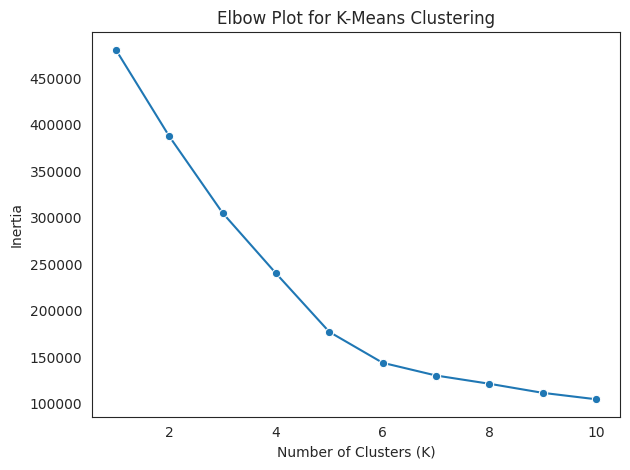

In [6]:
# Plot the elbow plot
sns.lineplot(x=range(1, 11), y=inertia, marker='o')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.tight_layout()

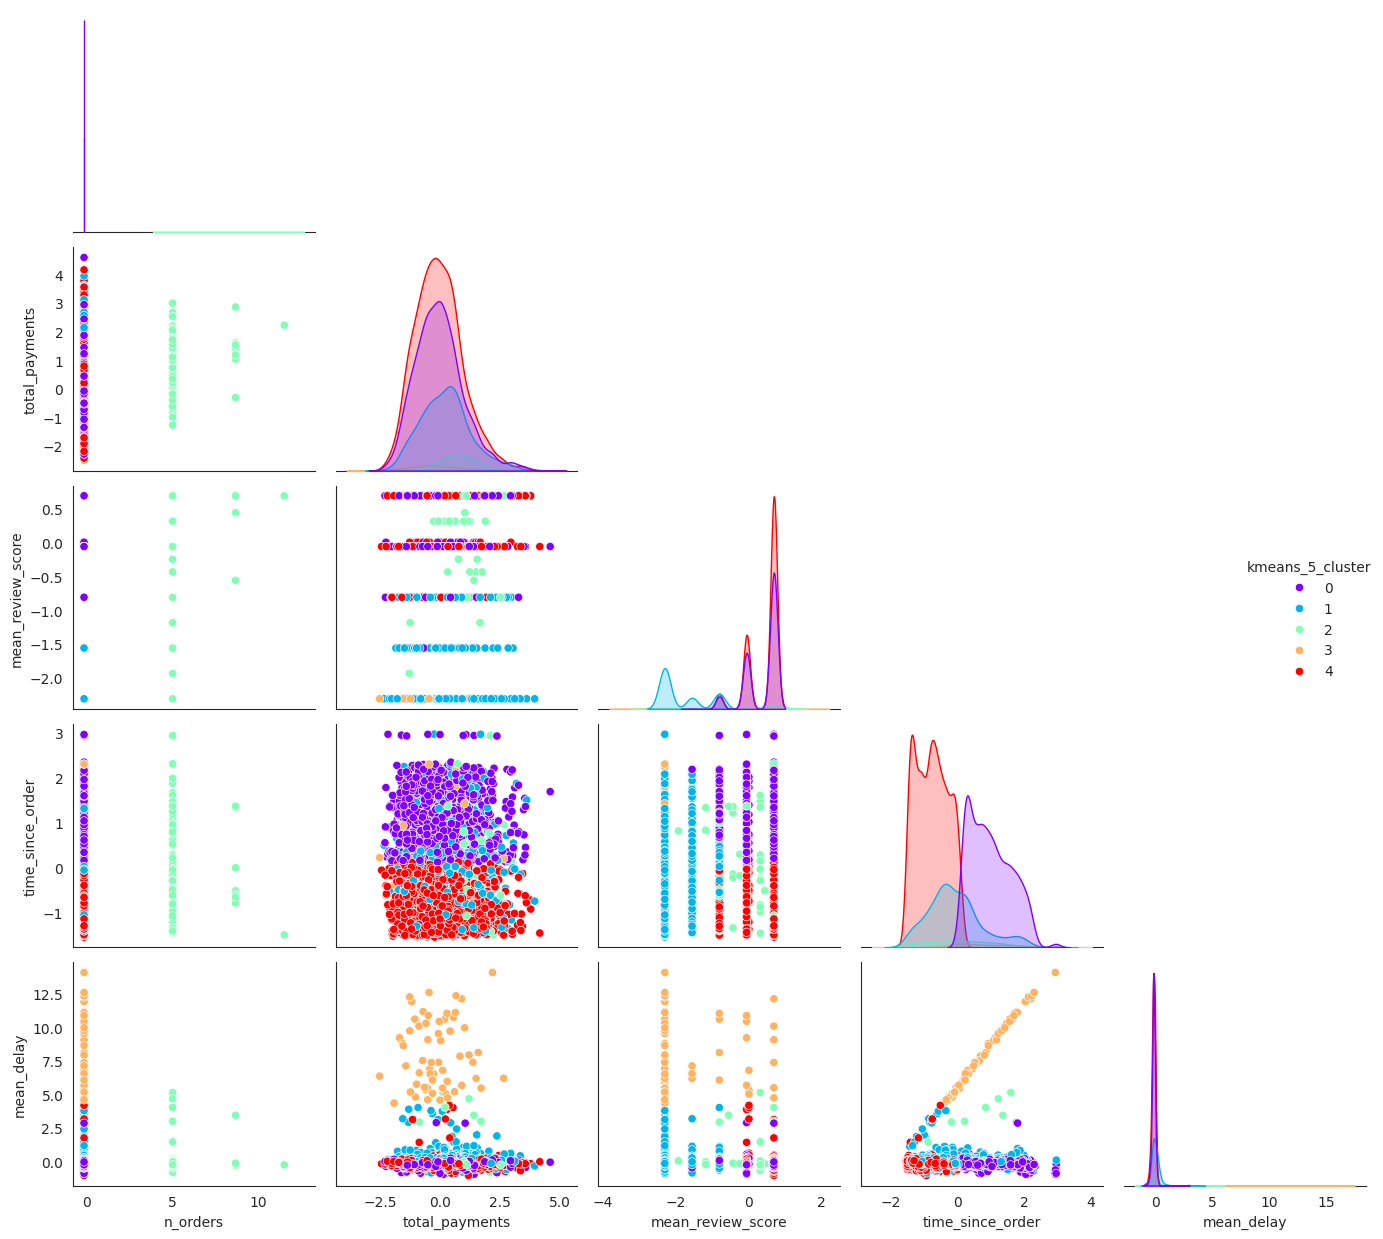

In [7]:
k = 5

cols = df.columns.tolist()[:len(features.columns)] + [f'kmeans_{k}_cluster']
sns.pairplot(
    df[cols].sample(5000),
    hue=f'kmeans_{k}_cluster',
    palette='rainbow',
    corner=True
)

plt.tight_layout()

# Cluster 0: past clients, satisfied, no delay
# Cluster 1: clients dissatisfied with some delay
# Cluster 2: clients with multiple orders
# Cluster 3: clients dissatisfied with lost orders and long delay
# Cluster 4: recent clients, satisfied, no delay

In [8]:
with open(drive_project_dir / f'k_means_{k}.pkl', 'wb') as f:
    pickle.dump(models[k], f)

In [ ]:
# DBSCAN clustering
param_grid = {
    'eps': [0.75, 1.0, 1.25, 1.5, 1.75],
    'min_samples': [5, 10, 15, 20, 25]
}

scores = dict()
models_dbscan = dict()

for (eps, min_samples) in list(product(
    param_grid['eps'],
    param_grid['min_samples']
)):
  print(f'Current DBSCAN: eps={eps}, min_samples={min_samples}')
  dbscan = DBSCAN(
      eps=eps,
      min_samples=min_samples,
      n_jobs=-1
  )
  df[f'dbscan_eps_{eps}_ms_{min_samples}'] = dbscan.fit_predict(features)
  score = silhouette_score(
      features,
      df[f'dbscan_eps_{eps}_ms_{min_samples}']
  )
  print(f'Silhouette score: {score}')
  scores[(eps, min_samples)] = score
  models_dbscan[(eps, min_samples)] = dbscan

Current DBSCAN: eps=0.75, min_samples=5
Silhouette score: 0.5724591266650708
Current DBSCAN: eps=0.75, min_samples=10
Silhouette score: 0.5391743448102381
Current DBSCAN: eps=0.75, min_samples=15
Silhouette score: 0.4321529752823281
Current DBSCAN: eps=0.75, min_samples=20
Silhouette score: 0.4177710610506197
Current DBSCAN: eps=0.75, min_samples=25
Silhouette score: 0.5868681045169801
Current DBSCAN: eps=1.0, min_samples=5
Silhouette score: 0.4237402277927248
Current DBSCAN: eps=1.0, min_samples=10
Silhouette score: 0.585401823591559
Current DBSCAN: eps=1.0, min_samples=15
Silhouette score: 0.5882176663264911
Current DBSCAN: eps=1.0, min_samples=20
Silhouette score: 0.5881400092337644
Current DBSCAN: eps=1.0, min_samples=25
Silhouette score: 0.5878756373141565
Current DBSCAN: eps=1.25, min_samples=5
Silhouette score: 0.5875185251041424
Current DBSCAN: eps=1.25, min_samples=10
Silhouette score: 0.5842013399785826
Current DBSCAN: eps=1.25, min_samples=15
Silhouette score: 0.581916072787

In [ ]:
cols = df.columns.tolist()[:len(features.columns)] + ['dbscan_cluster']
sns.pairplot(
    df[cols].sample(2000),
    hue='dbscan_cluster',
    palette='viridis',
    corner=True
)

plt.tight_layout()

KeyError: "['dbscan_cluster'] not in index"